<a href="https://colab.research.google.com/github/jiwan-gharti-savi/pytorch/blob/main/MultiClass_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
import torch
import torch.nn as nn

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np

In [46]:
NUM_SAMPLES = 1000
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

In [47]:
X_blob, y_blob = make_blobs(
    n_samples=NUM_SAMPLES,
    centers=NUM_CLASSES,
    n_features=NUM_FEATURES,
    random_state=RANDOM_SEED
)

In [48]:
X_blob, X_blob.shape


(array([[-8.55503989,  7.06461794],
        [-6.13753182, -6.58081701],
        [-6.32130028, -6.8041042 ],
        ...,
        [ 3.69047995,  4.60555175],
        [-7.48913939, -7.0670809 ],
        [-9.40049578,  7.11430104]]),
 (1000, 2))

In [49]:
X_blob = torch.from_numpy(X_blob).type(torch.float32)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

In [50]:
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

In [51]:
len(X_blob_train), len(X_blob_test)

(800, 200)

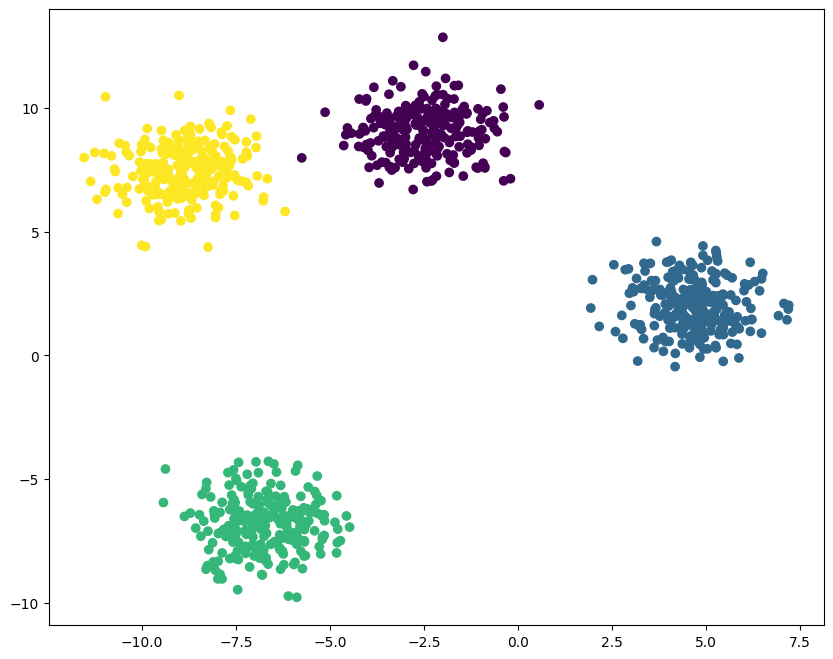

In [52]:
plt.figure(figsize=(10, 8))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob)

In [53]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [54]:
class MultiClassBlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_1 = nn.Linear(input_features, hidden_units)
    self.linear_layer_2 = nn.Linear(hidden_units, hidden_units)
    self.output_layer = nn.Linear(hidden_units, output_features)
    self.relu = nn.ReLU()

  def forward(self, x):
    return nn.Sequential(
        self.linear_layer_1,
        self.relu,
        self.linear_layer_2,
        self.relu,
        self.output_layer,
    )(x)

In [55]:
model = MultiClassBlobModel(input_features=NUM_FEATURES, output_features=NUM_CLASSES).to(device)

In [56]:
X_blob_train.shape, y_blob_train[:5]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0]))

In [57]:
torch.unique(y_blob_train)


tensor([0, 1, 2, 3])

In [58]:
# loss and optimizer
LEARNING_RATE = 0.01

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [59]:
with torch.inference_mode():
  logits = model(X_blob_train[:5])

logits

tensor([[-0.7097, -0.6568, -1.4328, -1.0505],
        [-0.2312, -1.2148, -0.9651, -0.2835],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [ 0.2471, -0.2418,  0.1720,  0.0051],
        [-0.1523, -1.0461, -0.7691, -0.2185]])

In [60]:
y_pred_prob = nn.Softmax(dim=1)(logits)
y_pred_prob

tensor([[0.3076, 0.3243, 0.1493, 0.2188],
        [0.3568, 0.1334, 0.1712, 0.3386],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3007, 0.1844, 0.2789, 0.2360],
        [0.3467, 0.1418, 0.1871, 0.3245]])

In [61]:
torch.round(nn.Softmax(dim=0)(logits))

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

In [62]:
torch.sum(y_pred_prob, dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

In [63]:
y_preds = torch.argmax(y_pred_prob, dim=1)
y_preds

tensor([1, 0, 0, 0, 0])

In [64]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

In [65]:
X_blob_train = X_blob_train.to(device)
y_blob_train = y_blob_train.to(device)
X_blob_test  = X_blob_test.to(device)
y_blob_test = y_blob_test.to(device)

In [66]:
y_blob_train[0], type(y_blob_train[0]), y_blob_train[0].dtype

(tensor(1), torch.Tensor, torch.int64)

In [67]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [69]:
epochs = 100

for epoch in range(epochs):
  model.train()

  y_logits = model(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  train_acc = accuracy_fn(y_blob_train, y_pred)

  loss = loss_fn(y_logits, y_blob_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  with torch.inference_mode():
    test_logits = model(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)

    test_acc = accuracy_fn(y_blob_test, test_pred)

  if epoch % 10 == 0:
    print(f'Epoch: {epoch} | Loss: {loss} | Train Accuracy: {train_acc} | Test Loss {test_loss} | Test Accuracy: {test_acc}')

Epoch: 0 | Loss: 0.6211187839508057 | Train Accuracy: 98.75 | Test Loss 0.6597306728363037 | Test Accuracy: 99.0
Epoch: 10 | Loss: 0.5960745215415955 | Train Accuracy: 99.0 | Test Loss 0.6337137818336487 | Test Accuracy: 99.5
Epoch: 20 | Loss: 0.5714306831359863 | Train Accuracy: 99.25 | Test Loss 0.6078600883483887 | Test Accuracy: 99.5
Epoch: 30 | Loss: 0.5467536449432373 | Train Accuracy: 99.625 | Test Loss 0.5818037986755371 | Test Accuracy: 100.0
Epoch: 40 | Loss: 0.5221951007843018 | Train Accuracy: 99.75 | Test Loss 0.5557901859283447 | Test Accuracy: 100.0
Epoch: 50 | Loss: 0.4978686571121216 | Train Accuracy: 99.75 | Test Loss 0.5298776030540466 | Test Accuracy: 100.0
Epoch: 60 | Loss: 0.4736948311328888 | Train Accuracy: 99.75 | Test Loss 0.5039688348770142 | Test Accuracy: 100.0
Epoch: 70 | Loss: 0.4497772455215454 | Train Accuracy: 99.75 | Test Loss 0.47824573516845703 | Test Accuracy: 100.0
Epoch: 80 | Loss: 0.4264318346977234 | Train Accuracy: 99.75 | Test Loss 0.45302116

In [71]:

model.eval()
with torch.inference_mode():
  y_logits = model(X_blob_test)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

y_pred

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

In [72]:
torch.eq(y_pred, y_blob_test)

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

In [73]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

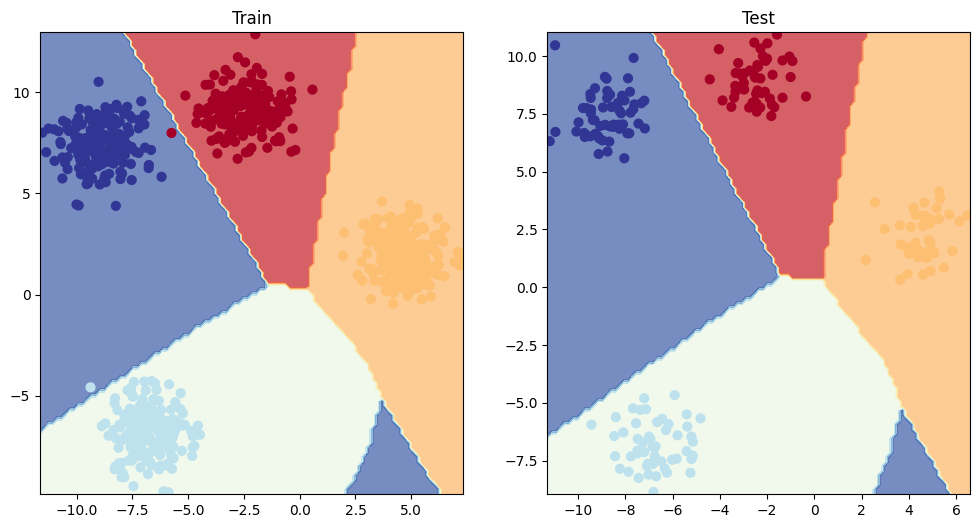

In [78]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_blob_test, y_blob_test)